In [ ]:
import sys

import numpy as np

sys.path.append("/home/cyprien/Documents/github/pytorch-forecasting")
sys.path.append("../")

import hashlib

from data_factory.preprocessing import *
from utilities.config import load_config

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

logging.basicConfig(level=DEBUG)
logger = logging.getLogger(__name__)
logger.setLevel(DEBUG)

In [ ]:
config_file = '../config/config.yml'
use_previous_files = False
export = False

In [ ]:
config = load_config(config_file)

model = config['model']
model_config = config[model]

# Create variables from config
#  data loading
save_folder = config['data']['save']
train_file = config['data']['train_path'] + config['data']['stock_prices']
test_file = config['data']['test_path'] + config['data']['stock_prices']

#  TimeSeries settings
max_prediction_length = model_config['sliding_window']['max_prediction_length']
min_prediction_length = model_config['sliding_window']['min_prediction_length']
max_encoder_length = model_config['sliding_window']['max_encoder_length']
min_encoder_length = model_config['sliding_window']['min_encoder_length']
batch_size = model_config['sliding_window']['batch_size']

related_stocks = model_config['related_stock']
train_val_split = model_config['train_val_split']
scale = model_config['manual_scale']

# define file name for saving StockPricesLoader with specific config
hash_ = hashlib.md5(model_config.__str__().encode('utf-8')).hexdigest()
export_file_name = f"{save_folder}/export_{hash_}.p"
logger.debug(f'Export file {export_file_name}')

logger.debug(f'Use config {config}')


### Load

In [ ]:
from data_factory.prepared_data import PreparedData

data: PreparedData = PreparedData.from_file("../data/save/preprocessed_data.pkl")
df_train = data.train
df_val = data.val
df_test = data.test

## Data Augmentation

#### Add related stocks

In [ ]:
cosine_business = pd.read_csv(config['data']['suppl'] + 'knowledge_graph_cosine_business', low_memory=False).rename(columns={'Unnamed: 0': 'ticker'})
cosine_financial = pd.read_csv(config['data']['suppl'] + 'knowledge_graph_cosine_financial', low_memory=False).rename(columns={'Unnamed: 0': 'ticker'})
cosine_sector = pd.read_csv(config['data']['suppl'] + 'knowledge_graph_cosine_sector', low_memory=False).rename(columns={'Unnamed: 0': 'ticker'})

cosine_business.set_index('ticker', inplace=True)
cosine_financial.set_index('ticker', inplace=True)
cosine_sector.set_index('ticker', inplace=True)

top_business = cosine_business.apply(lambda s: pd.Series(s.nlargest(related_stocks).index)).T.astype(str).rename(columns=str)
top_financial = cosine_financial.apply(lambda s: pd.Series(s.nlargest(related_stocks).index)).T.astype(str).rename(columns=str)
top_sector = cosine_sector.apply(lambda s: pd.Series(s.nlargest(related_stocks).index)).T.astype(str).rename(columns=str)

In [ ]:
missing_keys = list(set(df_train.SecuritiesCode.unique()) - set(cosine_business.columns))
logger.info(f"Len missing Securities Code in {config['data']['cosine']}: {len(missing_keys)}")

missing_keys = list(set(df_train.SecuritiesCode.unique()) - set(cosine_financial.columns))
logger.info(f"Len missing Securities Code in {config['data']['cosine']}: {len(missing_keys)}")

missing_keys = list(set(df_train.SecuritiesCode.unique()) - set(cosine_sector.columns))
logger.info(f"Len missing Securities Code in {config['data']['cosine']}: {len(missing_keys)}")

In [ ]:
def add_stocks(df: pd.DataFrame):
    for top, abbrev in tqdm(zip([top_business, top_financial, top_sector], ['b', 'f', 's']), total=3):
        for t, col in [(f'top{abbrev}_{i}', str(i)) for i in range(related_stocks)]:
            df[t] = df.SecuritiesCode.transform(lambda x: top.loc[x, col])

            valuable_cols = ['Close_scaled', 'predict_target']

            df = df.merge(
                df.loc[:, ['SecuritiesCode', 'Timestamp', *valuable_cols]],
                how='left', left_on=[t, 'Timestamp'], right_on=['SecuritiesCode', 'Timestamp'],
                suffixes=('', f'_{t}')
            ).drop(columns=[f'SecuritiesCode_{t}', t])
            #print(df.columns)

            # Makes every series with missing values = 0
            # FIXME
            # df[f'Close_scaled_{t}'] = df.groupby('SecuritiesCode')[f'Close_scaled_{t}'].apply(lambda x: pd.Series(np.zeros_like(x.to_numpy())) if x.isna().sum() != 0 else x).reset_index(drop=True)
            for c in valuable_cols:
                df[f'{c}_{t}'] = df.groupby('SecuritiesCode')[f'{c}_{t}'].apply(lambda x: pd.Series(np.zeros_like(x.to_numpy())) if x.isna().sum() != 0 else x).reset_index(drop=True)
    return df

df_train = add_stocks(df_train)
df_test = add_stocks(df_test)
df_val = add_stocks(df_val)

In [ ]:
for sc in df_train.SecuritiesCode.unique()[:3]:
    plt.plot(df_train.loc[df_train.SecuritiesCode == sc, 'Timestamp'], df_train.loc[df_train.SecuritiesCode == sc, 'predict_target'], alpha=.3)
    plt.plot(df_train.loc[df_train.SecuritiesCode == sc, 'Timestamp'], df_train.loc[df_train.SecuritiesCode == sc, 'predict_target_topb_0'], alpha=.3)
    plt.title(sc)
    plt.show()

### Add groups

In [ ]:
groups = pd.read_csv(config['data']['suppl'] + 'grouping.csv', low_memory=False).rename(
    columns={'BusinessReports': 'business_group', 'Sector': 'sector_group', 'FinancialGroup': 'financial_group'}
).drop(columns=["Unnamed: 0"])
groups.SecuritiesCode = groups.SecuritiesCode.astype(str)
groups.business_group = groups.business_group.astype(str)
groups.sector_group = groups.sector_group.astype(str)
groups.financial_group = groups.financial_group.astype(str)

groups.head(2)

In [ ]:
def add_groups(df: pd.DataFrame):

    df = df.merge(
        groups,
        how='left', 
        left_on=['SecuritiesCode'], right_on=['SecuritiesCode']
    )
    return df

df_train = add_groups(df_train)
df_test = add_groups(df_test)
df_val = add_groups(df_val)

### Moving average

In [ ]:
from itertools import product

c = 100

cols = list(product(['Close_scaled', 'predict_target'], [10, 3]))
example_sc = '9990'

def moving_average(df):
    plt.figure(figsize=(16, 4))
    plt.plot(df[df.SecuritiesCode == example_sc].Date.iloc[:c], df[df.SecuritiesCode == example_sc].Close_scaled.iloc[:c])
    for col, span in cols:
        df[f'{col}_ewm_{span}'] = df.groupby('SecuritiesCode')[col].ewm(span=span).mean().reset_index(drop=True)
        plt.plot(df[df.SecuritiesCode == example_sc].Date.iloc[:c],
                 df[df.SecuritiesCode == example_sc][f'{col}_ewm_{span}'].iloc[:c], label=f'{col}_ewm_{span}')
    plt.legend()
    plt.show()
    return df

df_train = moving_average(df_train)
df_test = moving_average(df_test)
df_val = moving_average(df_val)

Cross point

### Diff

In [ ]:
"""from itertools import product

cols = ['Close', 'Low', 'High'] + [f'{col}_ewm_{span}' for col, span in cols]
diffs = [1, 2, 3]

def differences(df: pd.DataFrame):
    for col, diff in product(cols, diffs):
        if 'target' not in col:
            s = df.groupby('SecuritiesCode')[col].apply(lambda x: x.diff(diff) / x.shift(1)).fillna(0).reset_index(drop=True).to_frame(f'{col}_diff{diff}')
        else:
            s = df.groupby('SecuritiesCode')[col].apply(lambda x: x.diff(diff)).fillna(0).reset_index(drop=True).to_frame(f'{col}_diff{diff}')
        df = pd.concat((df, s), axis=1)
    return df

df_train = differences(df_train)
df_test = differences(df_test)
df_val = differences(df_val)"""

### Moving average

In [ ]:
"""spans = [10, 5, 3]
cols_ma = [f'{col}_diff{diff}' for col, diff in product(cols, diffs)]

def moving_average(df):
    for col, span in tqdm(product(cols_ma, spans), total=len(cols_ma) * len(spans)):
        s = df.groupby('SecuritiesCode')[col].ewm(span=span).mean().reset_index(drop=True).to_frame(f'{col}_ewm_{span}')
        df = pd.concat((df, s), axis=1)
    return df

df_train = moving_average(df_train)
df_test = moving_average(df_test)
df_val = moving_average(df_val)"""

Cross point

### Day of week

In [ ]:
df_train['dayofweek'] = df_train.Date.dt.dayofweek.astype(str)
df_test['dayofweek'] = df_test.Date.dt.dayofweek.astype(str)
df_val['dayofweek'] = df_val.Date.dt.dayofweek.astype(str)

#### Timeseries

In [ ]:
df_train['Timestamp_1'] = df_train.groupby('SecuritiesCode').Timestamp.apply(lambda x: pd.Series(range(1, len(x)+1))).reset_index(drop=True)
df_val['Timestamp_1'] = df_val.groupby('SecuritiesCode').Timestamp.apply(lambda x: pd.Series(range(1, len(x)+1))).reset_index(drop=True)
df_test['Timestamp_1'] = df_test.groupby('SecuritiesCode').Timestamp.apply(lambda x: pd.Series(range(1, len(x)+1))).reset_index(drop=True)

### Export

In [ ]:
data = PreparedData(df_train, df_val, df_test, data.scalers)

In [ ]:
data.export('../data/save/augmented_data.pkl')

#### Some checks

In [ ]:
df_train[['predict_target', 'Target']]

#### Some checks

In [18]:
df_train[['predict_target', 'Target']]

,predict_target,Target
0,0.000000,-0.001092
1,0.000000,-0.005100
2,-0.001092,-0.003295
3,-0.005100,-0.006613
4,-0.003295,-0.006657
...,...,...
2211867,-0.006046,0.020433
2211868,0.012165,0.015312
2211869,0.020433,0.003480
2211870,0.015312,0.009249


#### Experiments

##### secondary stock prices


In [19]:


scp = pd.read_csv(config['data']['train_path'] + config['data']['secondary_stock_price'])
scp.head(2)


scp.shape, scp.SecuritiesCode.unique().size, len(set(scp.SecuritiesCode.unique()) - set(df_train.SecuritiesCode.unique()))



((2384575, 12), 2371, 2371)

##### trades

In [20]:
trades = pd.read_csv(config['data']['train_path'] + config['data']['trades'], parse_dates=['Date', 'StartDate', 'EndDate'])
trades.head(2)

,Date,StartDate,EndDate,Section,TotalSales,TotalPurchases,TotalTotal,TotalBalance,ProprietarySales,ProprietaryPurchases,...,CityBKsRegionalBKsEtcTotal,CityBKsRegionalBKsEtcBalance,TrustBanksSales,TrustBanksPurchases,TrustBanksTotal,TrustBanksBalance,OtherFinancialInstitutionsSales,OtherFinancialInstitutionsPurchases,OtherFinancialInstitutionsTotal,OtherFinancialInstitutionsBalance
0,2017-01-04,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-05,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
(trades.EndDate - trades.StartDate)[(trades.EndDate - trades.StartDate).notna()].value_counts()

4 days    633
3 days     96
2 days     15
1 days     15
0 days      6
dtype: int64

In [22]:
(trades.Date - trades.StartDate)[(trades.EndDate - trades.StartDate).notna()].value_counts()

10 days    600
9 days      87
11 days     24
15 days     15
14 days     15
7 days       9
16 days      6
8 days       6
18 days      3
dtype: int64

In [23]:
trades.shape, trades.columns

((1712, 56),
 Index(['Date', 'StartDate', 'EndDate', 'Section', 'TotalSales',
        'TotalPurchases', 'TotalTotal', 'TotalBalance', 'ProprietarySales',
        'ProprietaryPurchases', 'ProprietaryTotal', 'ProprietaryBalance',
        'BrokerageSales', 'BrokeragePurchases', 'BrokerageTotal',
        'BrokerageBalance', 'IndividualsSales', 'IndividualsPurchases',
        'IndividualsTotal', 'IndividualsBalance', 'ForeignersSales',
        'ForeignersPurchases', 'ForeignersTotal', 'ForeignersBalance',
        'SecuritiesCosSales', 'SecuritiesCosPurchases', 'SecuritiesCosTotal',
        'SecuritiesCosBalance', 'InvestmentTrustsSales',
        'InvestmentTrustsPurchases', 'InvestmentTrustsTotal',
        'InvestmentTrustsBalance', 'BusinessCosSales', 'BusinessCosPurchases',
        'BusinessCosTotal', 'BusinessCosBalance', 'OtherInstitutionsSales',
        'OtherInstitutionsPurchases', 'OtherInstitutionsTotal',
        'OtherInstitutionsBalance', 'InsuranceCosSales',
        'InsuranceCos

In [24]:
trades.Section.value_counts(), trades.Section.isnull().sum()

(Growth Market (Mothers/JASDAQ)      255
 Prime Market (First Section)        255
 Standard Market (Second Section)    255
 Name: Section, dtype: int64,
 947)

In [25]:
trades.columns[pd.Series(trades.columns).str.contains('Date')]

Index(['Date', 'StartDate', 'EndDate'], dtype='object')

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manage

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/pyt

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ttf-khmeros-core/KhmerOS.ttf', name='Khmer OS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Yrsa-SemiBoldItalic.ttf', name='Yrsa', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', name='Liberation Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationMono-BoldItalic.ttf', name='Liberation Mono', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(Fo

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', name='Liberation Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Rasa-SemiBold.ttf', name='Rasa', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Kinnari.ttf', name='Kinnari', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/teluguvijayam/Ponnala.ttf', name='Ponnala', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lib

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-bengali/Lohit-Bengali.ttf', name='Lohit Bengali', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/C059-Roman.otf', name='C059', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Umpush-LightOblique.ttf', name='Umpush', style='oblique', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/samyak/Samyak-Devanagari.ttf', name='Samyak Devanagari', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/t

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/teluguvijayam/Ramaraja-Regular.ttf', name='Ramaraja', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-beng-extra/LikhanNormal.ttf', name='Likhan', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-B.ttf', name='Ubuntu Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', name='Liberation Sans Narrow', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(F

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuMathTeXGyre.ttf', name='DejaVu Math TeX Gyre', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypewriter.ttf', name='Tlwg Typewriter', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeSerif.ttf', name='FreeSerif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Sawasdee-BoldOblique.ttf', name='Sawasdee', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Norasi-Italic.ttf', name='Norasi', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Laksaman-BoldItalic.ttf', name='Laksaman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Kinnari-BoldObl

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/teluguvijayam/PottiSreeramulu.ttf', name='Potti Sreeramulu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/P052-BoldItalic.otf', name='P052', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusMonoPS-Regular.otf', name='Nimbus Mono PS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Garuda-Oblique.ttf', name='Garuda', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', name='Liberation Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-beng-extra/Mukti.ttf', name='Mukti', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/malayalam/RaghuMalayalamSans-Regular.ttf', name='RaghuMalayalamSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSerif-Bold.ttf', name='Liberation Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont:

<AxesSubplot:xlabel='Date', ylabel='TotalSales'>

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manage

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/pyt

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ttf-khmeros-core/KhmerOS.ttf', name='Khmer OS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Yrsa-SemiBoldItalic.ttf', name='Yrsa', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', name='Liberation Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationMono-BoldItalic.ttf', name='Liberation Mono', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(Fo

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', name='Liberation Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Rasa-SemiBold.ttf', name='Rasa', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Kinnari.ttf', name='Kinnari', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/teluguvijayam/Ponnala.ttf', name='Ponnala', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lib

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-bengali/Lohit-Bengali.ttf', name='Lohit Bengali', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/C059-Roman.otf', name='C059', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Umpush-LightOblique.ttf', name='Umpush', style='oblique', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/samyak/Samyak-Devanagari.ttf', name='Samyak Devanagari', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/t

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/teluguvijayam/Ramaraja-Regular.ttf', name='Ramaraja', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-beng-extra/LikhanNormal.ttf', name='Likhan', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-B.ttf', name='Ubuntu Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', name='Liberation Sans Narrow', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(F

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuMathTeXGyre.ttf', name='DejaVu Math TeX Gyre', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypewriter.ttf', name='Tlwg Typewriter', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeSerif.ttf', name='FreeSerif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Sawasdee-BoldOblique.ttf', name='Sawasdee', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Norasi-Italic.ttf', name='Norasi', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Laksaman-BoldItalic.ttf', name='Laksaman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Kinnari-BoldObl

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/teluguvijayam/PottiSreeramulu.ttf', name='Potti Sreeramulu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/P052-BoldItalic.otf', name='P052', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusMonoPS-Regular.otf', name='Nimbus Mono PS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Garuda-Oblique.ttf', name='Garuda', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', name='Liberation Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-beng-extra/Mukti.ttf', name='Mukti', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/malayalam/RaghuMalayalamSans-Regular.ttf', name='RaghuMalayalamSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSerif-Bold.ttf', name='Liberation Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont:

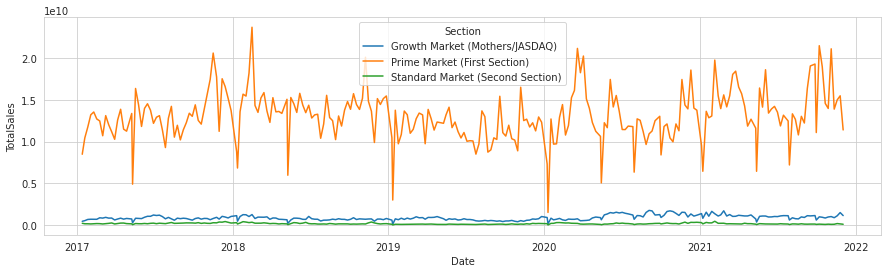

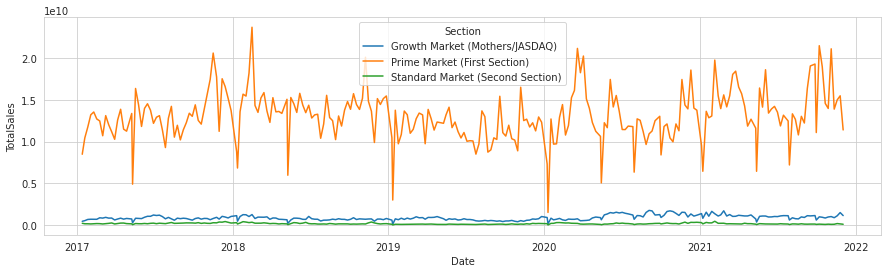

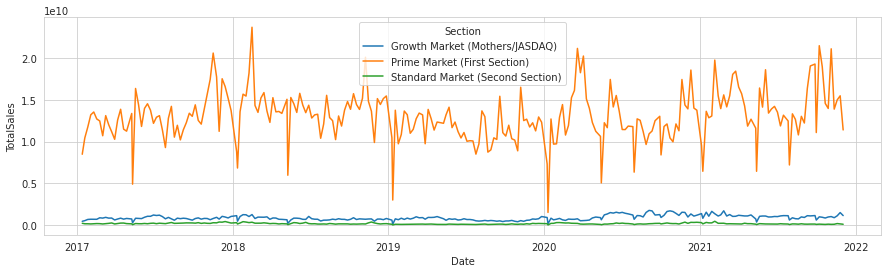

In [26]:
import seaborn as sns
sns.set_style("whitegrid")

figure = plt.figure(figsize=(15, 4))
sns.lineplot(x='Date', y='TotalSales', hue='Section', data=trades, figure=figure)

figure = plt.figure(figsize=(15, 4))
sns.lineplot(x='Date', y='TotalSales', hue='Section', data=trades, figure=figure)

figure = plt.figure(figsize=(15, 4))
sns.lineplot(x='Date', y='TotalSales', hue='Section', data=trades, figure=figure)


##### options

In [27]:
options = pd.read_csv(config['data']['train_path'] + config['data']['options'], parse_dates=['Date', 'LastTradingDay', 'SpecialQuotationDay'])
options.shape


/tmp/ipykernel_211740/2049952651.py:1: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  options = pd.read_csv(config['data']['train_path'] + config['data']['options'], parse_dates=['Date', 'LastTradingDay', 'SpecialQuotationDay'])


(3567694, 31)

In [28]:
options.columns

Index(['DateCode', 'Date', 'OptionsCode', 'WholeDayOpen', 'WholeDayHigh',
       'WholeDayLow', 'WholeDayClose', 'NightSessionOpen', 'NightSessionHigh',
       'NightSessionLow', 'NightSessionClose', 'DaySessionOpen',
       'DaySessionHigh', 'DaySessionLow', 'DaySessionClose', 'TradingVolume',
       'OpenInterest', 'TradingValue', 'ContractMonth', 'StrikePrice',
       'WholeDayVolume', 'Putcall', 'LastTradingDay', 'SpecialQuotationDay',
       'SettlementPrice', 'TheoreticalPrice', 'BaseVolatility',
       'ImpliedVolatility', 'InterestRate', 'DividendRate', 'Dividend'],
      dtype='object')

In [29]:
options.OptionsCode.astype(str).str[1].value_counts()

3    1249551
4    1249551
8     534296
9     534296
Name: OptionsCode, dtype: int64

In [30]:
options.OptionsCode.astype(str).str[2:5].value_counts()

612    154760
606    150456
512    135364
706    129526
712    125848
        ...  
614        84
414        52
415        46
936        46
515        12
Name: OptionsCode, Length: 122, dtype: int64

In [31]:
options.OptionsCode.astype(str).str[7:9].value_counts()

18    3567694
Name: OptionsCode, dtype: int64

In [32]:
options[['Date', 'LastTradingDay', 'SpecialQuotationDay', 'OptionsCode']]

,Date,LastTradingDay,SpecialQuotationDay,OptionsCode
0,2017-01-04,2017-01-12,2017-01-13,132010018
1,2017-01-04,2017-01-12,2017-01-13,132010118
2,2017-01-04,2017-01-12,2017-01-13,132010218
3,2017-01-04,2017-01-12,2017-01-13,132010318
4,2017-01-04,2017-01-12,2017-01-13,132010518
...,...,...,...,...
3567689,2021-12-03,2024-12-12,2024-12-13,199244018
3567690,2021-12-03,2024-12-12,2024-12-13,199245018
3567691,2021-12-03,2024-12-12,2024-12-13,199246018
3567692,2021-12-03,2024-12-12,2024-12-13,199247018
